# Loading and Displaying Well Log Data from LAS

**Created by:** Andy McDonald  
  
This notebook illustrates how to load data in from a LAS file and carry out a basic QC of the data before plotting it on a log plot.

## Loading and Checking Data
The first step is to import the required libraries: pandas, matplotlib and LASIO.  
lasio is a library that has been developed to handle and work with LAS files. More info on the library can be found at: https://lasio.readthedocs.io/en/latest/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lasio

To load our file in, we can use the read() method from LASIO like so:

In [2]:
las = lasio.read("Data/15-9-19_SR_COMP.LAS")

Now that our file has been loaded, we can start investigating it's contents.  
To find information out about where the file originated from, such as the well name, location and what the depth range of the file covers, we can create a simple for loop to go over each header item. Using Python's f-string we can join the items together.

In [3]:
for item in las.well:
    print(f"{item.descr} ({item.mnemonic}): {item.value}")

Top Depth (STRT): 102.1568
Bottom Depth (STOP): 4636.514
Depth Increment (STEP): 0.1524
Null Value (NULL): -999.25
Field Name (FLD): Q15
NAME (WELL): 15/9-19
WELLBORE (WBN): 15/9-19 SR
COUNTRY (NATI): NOR
COUNTRY (CTRY): NOR
OPERATOR (COMP): STATOIL
PERM DATUM (PDAT): MSL
RIG NAME (COUN): NORTH SEA
STATE (STAT): NORWAY
PB WELL ID (PBWE): 15/9-19
PB WELLBORE ID (APIN): 15/9-19 SR
PB WELL NAME SET (PBWS): ALL


If we just want to extract the Well Name, we can simply call it by:

In [4]:
las.well.WELL.value

'15/9-19'

To quickly see what curves are present within the las file we can loop through `las.curves`

In [5]:
for curve in las.curves:
    print(curve.mnemonic)

DEPT
AC
CALI
DEN
GR
NEU
RDEP
RMED


To see what curves are present within the las file, we can repeat the process with the CurveItem object and call upon the `unit` and `descr` functions to get info on the units and the curve's description.
The enumerate function allows us to keep a count of the number of curves that are present within the file. As enumerate returns a 0 on the first loop, we need to 1 to it if we want to include the depth curve.

In [6]:
for count, curve in enumerate(las.curves):
    print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
print(f"There are a total of: {count+1} curves present within this file")

Curve: DEPT, Units: M, Description: 1  DEPTH
Curve: AC, Units: US/F, Description: 2  Sonic Transit Time (Slowness)
Curve: CALI, Units: IN, Description: 3  Caliper
Curve: DEN, Units: G/CC, Description: 4  Bulk Density
Curve: GR, Units: GAPI, Description: 5  Gamma Ray
Curve: NEU, Units: %, Description: 6  Neutron Porosity
Curve: RDEP, Units: OHMM, Description: 7  Deep Resistivity
Curve: RMED, Units: OHMM, Description: 8  Medium Resistivity
There are a total of: 8 curves present within this file


## Creating a Pandas Dataframe
Data loaded in using LASIO can be converted to a pandas dataframe using the .df() function. This allows us to easily plot data and pass it into one of the many machine learning algorithms.

In [7]:
well = las.df()

The `.head()` function generates a table view of the header and the first 5 rows within the dataframe.

In [8]:
well.head()

,AC,CALI,DEN,GR,NEU,RDEP,RMED
DEPT,,,,,,,
102.1568,NaN,NaN,NaN,5.3274,NaN,NaN,NaN
102.3092,NaN,NaN,NaN,5.8235,NaN,NaN,NaN
102.4616,NaN,NaN,NaN,6.5228,NaN,NaN,NaN
102.6140,NaN,NaN,NaN,7.2285,NaN,NaN,NaN
102.7664,NaN,NaN,NaN,9.5020,NaN,NaN,NaN


To find out more information about data, we can call upon the `.info()` and `.describe()` functions.  
    
The `.info()` function provides information about the data types and how many non-null values are present within each curve.  
The `.describe()` function, provides statistical information about each curve and can be a useful QC for each curve.

In [9]:
well.describe()

,AC,CALI,DEN,GR,NEU,RDEP,RMED
count,7007.000000,7007.000000,7084.000000,28117.000000,7096.000000,12223.000000,12223.000000
mean,79.498714,9.611068,2.449055,71.986798,20.117166,2.438382,2.386781
std,18.390705,1.019751,0.165122,32.922780,14.729530,6.631202,5.735731
min,1.025100,6.000000,1.943000,2.766100,2.178300,0.250300,0.179000
25%,66.154350,9.142900,2.319975,50.255200,10.631350,0.988000,0.847850
50%,74.661900,9.589400,2.505600,74.998500,15.718550,1.536100,1.490800
75%,93.304550,9.904800,2.585125,92.343800,25.067375,2.434050,2.415400
max,181.813900,20.330400,3.001300,304.333700,146.347400,198.537100,168.604400


In [10]:
well.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 29754 entries, 102.1568 to 4636.514
Data columns (total 7 columns):
AC      7007 non-null float64
CALI    7007 non-null float64
DEN     7084 non-null float64
GR      28117 non-null float64
NEU     7096 non-null float64
RDEP    12223 non-null float64
RMED    12223 non-null float64
dtypes: float64(7)
memory usage: 1.8 MB


## Visualising Data Extent

Instead of the summary provided by the pandas describe() function, we can create a visualisation using matplotlib. Firstly, we need to work out where we have nulls (nan values). We can do this by creating a second dataframe and calling .notnull() on our well dataframe.  
  
As this returns a boolean (True or False) for each depth, we need to multiply by 1 to convert the values from True and False to 1 and 0 respectively.

In [11]:
well_nan = well.notnull() * 1

In [12]:
well_nan.head()

,AC,CALI,DEN,GR,NEU,RDEP,RMED
DEPT,,,,,,,
102.1568,0,0,0,1,0,0,0
102.3092,0,0,0,1,0,0,0
102.4616,0,0,0,1,0,0,0
102.6140,0,0,0,1,0,0,0
102.7664,0,0,0,1,0,0,0


We can now create a summary plot of the missing data

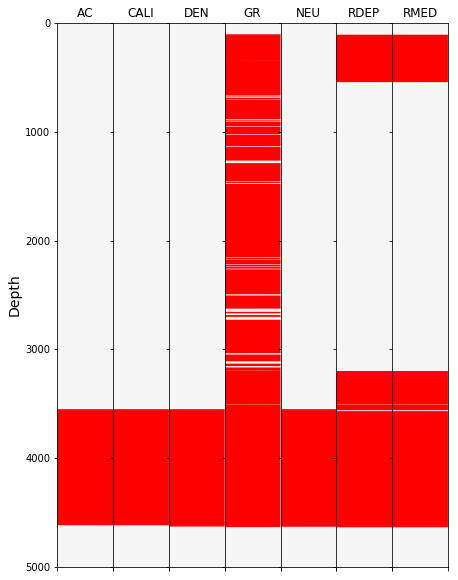

In [13]:
fig = plt.subplots(figsize=(7,10))

#Set up the plot axes
ax1 = plt.subplot2grid((1,7), (0,0), rowspan=1, colspan = 1) 
ax2 = plt.subplot2grid((1,7), (0,1), rowspan=1, colspan = 1)
ax3 = plt.subplot2grid((1,7), (0,2), rowspan=1, colspan = 1)
ax4 = plt.subplot2grid((1,7), (0,3), rowspan=1, colspan = 1)
ax5 = plt.subplot2grid((1,7), (0,4), rowspan=1, colspan = 1)
ax6 = plt.subplot2grid((1,7), (0,5), rowspan=1, colspan = 1)
ax7 = plt.subplot2grid((1,7), (0,6), rowspan=1, colspan = 1)

columns = well_nan.columns
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

for i, ax in enumerate(axes):
    ax.plot(well_nan.iloc[:,i], well_nan.index, lw=0)
    ax.set_ylim(5000, 0)
    ax.set_xlim(0, 1)
    ax.set_title(columns[i])
    ax.set_facecolor('whitesmoke')
    ax.fill_betweenx(well_nan.index, 0, well_nan.iloc[:,i], facecolor='red')
    # Remove tick labels from each subplot
    if i > 0:
        plt.setp(ax.get_yticklabels(), visible = False)
    plt.setp(ax.get_xticklabels(), visible = False)

ax1.set_ylabel('Depth', fontsize=14)

plt.subplots_adjust(wspace=0)
plt.show()

## Plotting Log Data
Finally, we can plot our data using the code below. Essentially, the code is building up a series of subplots and plotting the data on the relevant tracks.  
  
When we add curves to the tracks, we need to set the curve's properties, including the limits, colour and labels. We can also specify the shading between curves. An example has been added to the caliper curve to show shading between a bitsize value (8.5") and the CALI curve.  
  
If there are a number of features that are common between the plots, we can iterate over them using a for loop.

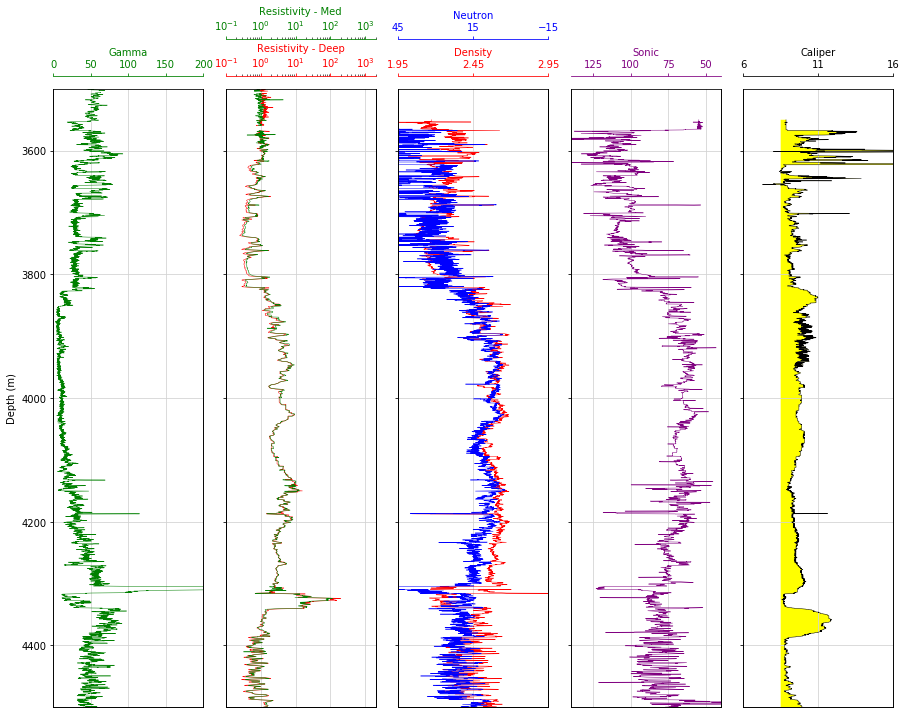

In [14]:
fig, ax = plt.subplots(figsize=(15,10))

#Set up the plot axes
ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1, sharey = ax1)
ax3 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1, sharey = ax1)
ax4 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1, sharey = ax1)
ax5 = ax3.twiny() #Twins the y-axis for the density track with the neutron track
ax6 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan = 1, sharey = ax1)
ax7 = ax2.twiny()

# As our curve scales will be detached from the top of the track,
# this code adds the top border back in without dealing with splines
ax10 = ax1.twiny()
ax10.xaxis.set_visible(False)
ax11 = ax2.twiny()
ax11.xaxis.set_visible(False)
ax12 = ax3.twiny()
ax12.xaxis.set_visible(False)
ax13 = ax4.twiny()
ax13.xaxis.set_visible(False)
ax14 = ax6.twiny()
ax14.xaxis.set_visible(False)

# Gamma Ray track
ax1.plot(well["GR"], well.index, color = "green", linewidth = 0.5)
ax1.set_xlabel("Gamma")
ax1.xaxis.label.set_color("green")
ax1.set_xlim(0, 200)
ax1.set_ylabel("Depth (m)")
ax1.tick_params(axis='x', colors="green")
ax1.spines["top"].set_edgecolor("green")
ax1.title.set_color('green')
ax1.set_xticks([0, 50, 100, 150, 200])

# Resistivity track
ax2.plot(well["RDEP"], well.index, color = "red", linewidth = 0.5)
ax2.set_xlabel("Resistivity - Deep")
ax2.set_xlim(0.2, 2000)
ax2.xaxis.label.set_color("red")
ax2.tick_params(axis='x', colors="red")
ax2.spines["top"].set_edgecolor("red")
ax2.set_xticks([0.1, 1, 10, 100, 1000])
ax2.semilogx()

# Density track
ax3.plot(well["DEN"], well.index, color = "red", linewidth = 0.5)
ax3.set_xlabel("Density")
ax3.set_xlim(1.95, 2.95)
ax3.xaxis.label.set_color("red")
ax3.tick_params(axis='x', colors="red")
ax3.spines["top"].set_edgecolor("red")
ax3.set_xticks([1.95, 2.45, 2.95])

# Sonic track
ax4.plot(well["AC"], well.index, color = "purple", linewidth = 0.5)
ax4.set_xlabel("Sonic")
ax4.set_xlim(140, 40)
ax4.xaxis.label.set_color("purple")
ax4.tick_params(axis='x', colors="purple")
ax4.spines["top"].set_edgecolor("purple")

# Neutron track placed ontop of density track
ax5.plot(well["NEU"], well.index, color = "blue", linewidth = 0.5)
ax5.set_xlabel('Neutron')
ax5.xaxis.label.set_color("blue")
ax5.set_xlim(45, -15)
ax5.set_ylim(4150, 3500)
ax5.tick_params(axis='x', colors="blue")
ax5.spines["top"].set_position(("axes", 1.08))
ax5.spines["top"].set_visible(True)
ax5.spines["top"].set_edgecolor("blue")
ax5.set_xticks([45,  15, -15])

# Caliper track
ax6.plot(well["CALI"], well.index, color = "black", linewidth = 0.5)
ax6.set_xlabel("Caliper")
ax6.set_xlim(6, 16)
ax6.xaxis.label.set_color("black")
ax6.tick_params(axis='x', colors="black")
ax6.spines["top"].set_edgecolor("black")
ax6.fill_betweenx(well_nan.index, 8.5, well["CALI"], facecolor='yellow')
ax6.set_xticks([6,  11, 16])

# Resistivity track - Curve 2
ax7.plot(well["RMED"], well.index, color = "green", linewidth = 0.5)
ax7.set_xlabel("Resistivity - Med")
ax7.set_xlim(0.2, 2000)
ax7.xaxis.label.set_color("green")
ax7.spines["top"].set_position(("axes", 1.08))
ax7.spines["top"].set_visible(True)
ax7.tick_params(axis='x', colors="green")
ax7.spines["top"].set_edgecolor("green")
ax7.set_xticks([0.1, 1, 10, 100, 1000])
ax7.semilogx()


# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2, ax3, ax4, ax6]:
    ax.set_ylim(4500, 3500)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", 1.02))
    
    
for ax in [ax2, ax3, ax4, ax6]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.15)